In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.svm import SVR


##### import feature sets:

In [6]:
feature_sets = []
feature_set_labels = []

# import three base feature sets
feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_PCA_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 PCs')
# ... rename principal component columns to be more descriptive
feature_sets[0] = feature_sets[0].rename(columns = dict([[str(i), 'stoich45 PC '+str(i+1)] for i in range(8)]))

feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_FeatureSelected_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 intersection')

feature_sets.append(pd.read_csv('../data/datasets_main/SCM_PCA_trainingStoich45_dataset.csv', sep=','))
feature_set_labels.append('SCM PCs')

# merge to form last two
feature_sets.append(feature_sets[0].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 PCs + SCM PCs')

feature_sets.append(feature_sets[1].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 intersection + SCM PCs')

# drop MOF column and rename target in all feature sets
feature_sets = [fs.drop(columns = ['MOF']).rename(columns = {'outputs.hse06.bandgap': 'HSE06 Bandgap'}) for fs in feature_sets]

##### make defintions for cross validation:

In [7]:
target = 'HSE06 Bandgap'
kfold = KFold(n_splits = 4, shuffle = True, random_state = 1234)

def get_mean_cv_mse(model, df_feature_set):
     return -cross_val_score(
         model,
         X = df_feature_set.drop(columns = [target]), y = df_feature_set[target],
         cv = kfold, scoring = 'neg_mean_squared_error',
         n_jobs = 4
     ).mean()

# Ensemble model approach to combine predictions from multiple base models
As different models may capture different patterns or reduce variance/bias, and seeing the individual performance of these models, it would be worthwhile to test when combined if they outperform the single models.

Two types of ensemble approaches will be tested:

1. Stacking: Combine predictions from multiple different model types (e.g., LightGBM, SVR, Ridge) by training a meta-model on their predictions.

2. Averaging/Weighted averaging: Just take predictions from several models and average them (or do a weighted average). Useful when base models are diverse and all decent performers.

## 1. Stacking Ensemble Model

In [ ]:
# Data storage
results = []

# Print header
print(f"{'Feature Set':<35} {'Stacking CV MSE':<20} {'Averaging CV MSE':<20} {'Weighted Avg CV MSE':<20}")

# Tweak weights for weighted average here
weights = np.array([0.4, 0.4, 0.2])  # RFM, LGBM, SVR

for i, fs in enumerate(feature_sets):
    X = fs.drop(columns=[target])
    y = fs[target]

    # Define base models
    rfm = RandomForestRegressor(n_estimators=100, random_state=1234)
    lgbm = LGBMRegressor(random_state=1234)
    svr = SVR()

    # Clone models
    base_models = [('rfm', clone(rfm)), ('lgbm', clone(lgbm)), ('svr', clone(svr))]
    meta_model = Ridge()

    # --- Stacking ---
    stack_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        passthrough=False
    )
    stack_model.fit(X, y)
    mse_stack = get_mean_cv_mse(stack_model, fs)

    # --- Averaging and Weighted Averaging ---
    preds_cv = []
    model_mses = []
    for model in [rfm, lgbm, svr]:
        model_clone = clone(model)
        model_clone.fit(X, y)
        scores = cross_val_score(model_clone, X, y, cv=5, scoring='neg_mean_squared_error')
        preds_cv.append(scores)
        model_mses.append(-np.mean(scores))

    avg_mse = -np.mean(np.mean(preds_cv, axis=0))  # Simple average
    weighted_mse = np.average(model_mses, weights=weights)

    # Logging results
    print(f"{feature_set_labels[i]:<35} {round(mse_stack, 6):<20} {round(avg_mse, 6):<20} {round(weighted_mse, 6):<20}")
    results.append({
        'Feature Set': feature_set_labels[i],
        'Stacking CV MSE': mse_stack,
        'Averaging CV MSE': avg_mse,
        'Weighted Averaging CV MSE': weighted_mse
    })


Feature Set                         Stacking CV MSE      Averaging CV MSE     Weighted Avg CV MSE 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8354, number of used features: 8
[LightGBM] [Info] Start training from score 3.846626
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6683, number of used features: 8
[LightGBM] [Info] Start training from score 3.841107
[LightGBM] [Warning] Found whitespace in feature_names, repla

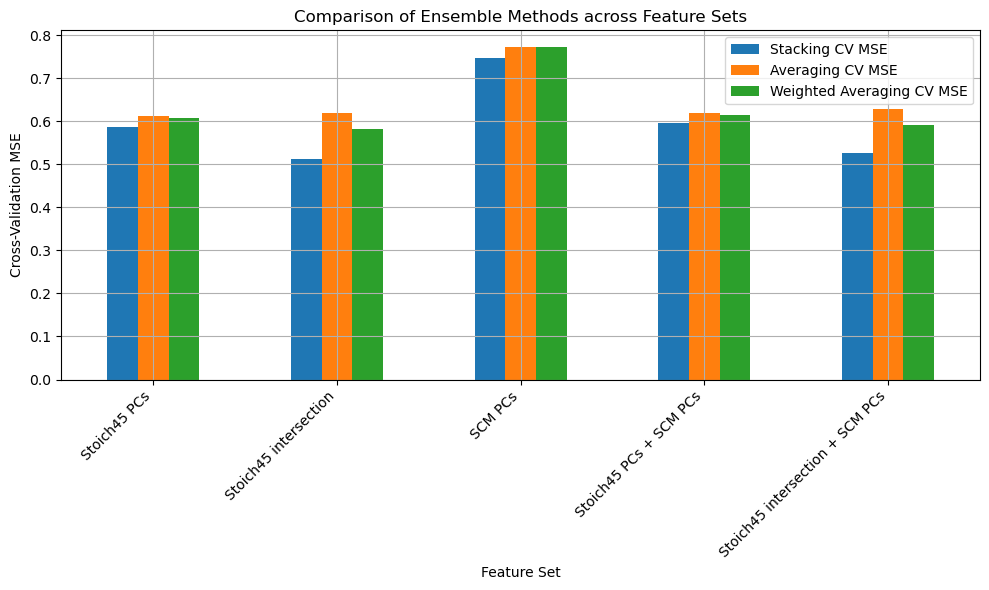

In [9]:
# --- Save and plot results ---
results_df = pd.DataFrame(results)

# Optional: Save to CSV
# results_df.to_csv("mof_bandgap_cv_results.csv", index=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
results_df.plot(x='Feature Set', kind='bar', ax=ax)
plt.ylabel("Cross-Validation MSE")
plt.title("Comparison of Ensemble Methods across Feature Sets")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

Feature Set                         RFM        LGBM       SVR        Stacking     Averaging    Weighted Avg   
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8354, number of used features: 8
[LightGBM] [Info] Start training from score 3.846626
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove t

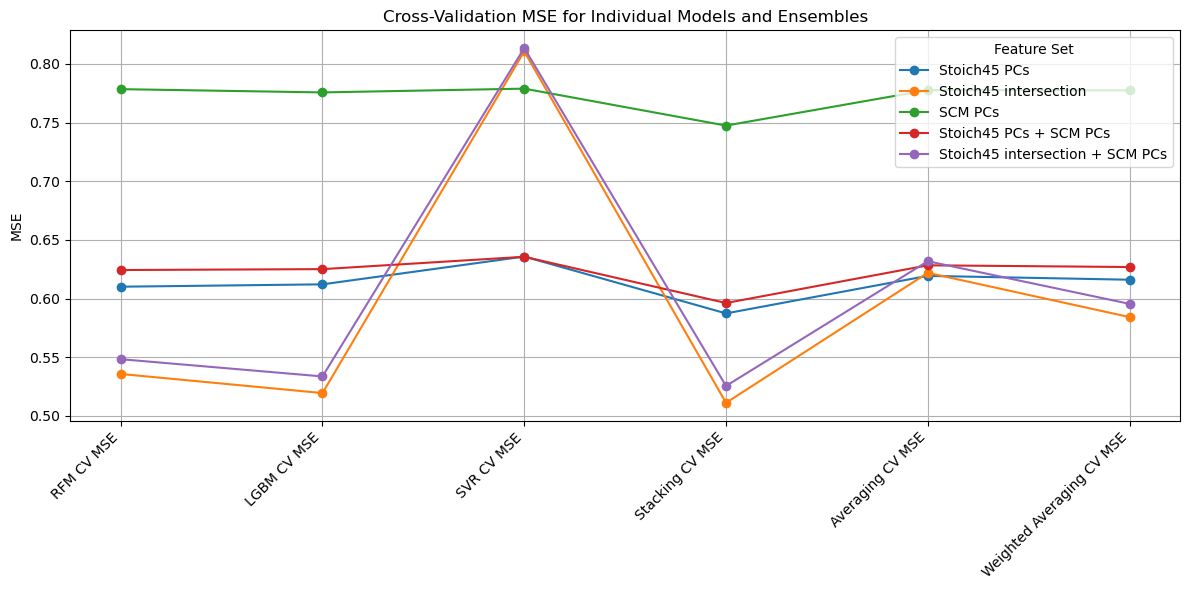

In [ ]:
# Data storage
results = []

# Print header
print(f"{'Feature Set':<35} {'RFM':<10} {'LGBM':<10} {'SVR':<10} {'Stacking':<12} {'Averaging':<12} {'Weighted Avg':<15}")

# Set weights for weighted averaging here (RFM, LGBM, SVR)
weights = np.array([0.4, 0.4, 0.2])

for i, fs in enumerate(feature_sets):
    X = fs.drop(columns=[target])
    y = fs[target]

    # Base models
    rfm = RandomForestRegressor(n_estimators=100, random_state=1234)
    lgbm = LGBMRegressor(random_state=1234)
    svr = SVR()

    model_names = ['RFM', 'LGBM', 'SVR']
    base_models = [rfm, lgbm, svr]
    model_mses = []

    # Evaluate individual models
    for model in base_models:
        model_clone = clone(model)
        model_clone.fit(X, y)
        mse = get_mean_cv_mse(model_clone, fs)
        model_mses.append(mse)

    # --- Stacking Ensemble ---
    stacked_model = StackingRegressor(
        estimators=[(name.lower(), clone(model)) for name, model in zip(model_names, base_models)],
        final_estimator=Ridge(),
        cv=5,
        passthrough=False
    )
    stacked_model.fit(X, y)
    mse_stacking = get_mean_cv_mse(stacked_model, fs)

    # --- Simple Averaging ---
    mse_avg = np.mean(model_mses)

    # --- Weighted Averaging ---
    mse_weighted = np.average(model_mses, weights=weights)

    # Logging
    print(f"{feature_set_labels[i]:<35} {round(model_mses[0], 4):<10} {round(model_mses[1], 4):<10} {round(model_mses[2], 4):<10} "
          f"{round(mse_stacking, 4):<12} {round(mse_avg, 4):<12} {round(mse_weighted, 4):<15}")

    results.append({
        'Feature Set': feature_set_labels[i],
        'RFM CV MSE': model_mses[0],
        'LGBM CV MSE': model_mses[1],
        'SVR CV MSE': model_mses[2],
        'Stacking CV MSE': mse_stacking,
        'Averaging CV MSE': mse_avg,
        'Weighted Averaging CV MSE': mse_weighted
    })

# --- Save & Plot ---
results_df = pd.DataFrame(results)

# Optional: Save to CSV
# results_df.to_csv("mof_bandgap_model_comparison.csv", index=False)

# Plotting
melted = results_df.melt(id_vars='Feature Set', var_name='Model', value_name='CV MSE')

plt.figure(figsize=(12, 6))
for label in results_df['Feature Set']:
    subset = melted[melted['Feature Set'] == label]
    plt.plot(subset['Model'], subset['CV MSE'], marker='o', label=label)

plt.title("Cross-Validation MSE for Individual Models and Ensembles")
plt.xticks(rotation=45, ha='right')
plt.ylabel("MSE")
plt.legend(title='Feature Set')
plt.grid(True)
plt.tight_layout()
plt.show()